In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np

import csv
import shutil
from datetime import datetime

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F

from dataset.e_piano import create_epiano_datasets, create_pop909_datasets

from model.music_transformer import MusicTransformer

from model.discriminator import MusicDiscriminator
from model.classifier import CNNDiscriminator

from model.loss import SmoothCrossEntropyLoss

from utilities.constants import *
from utilities.WGAN_GP import WassersteinLoss
from utilities.device import get_device, use_cuda
from utilities.lr_scheduling import LrStepTracker, get_lr
from utilities.argument_funcs import parse_train_args, print_train_args, write_model_params
from utilities.run_model import train_epoch, eval_model

dis_filter_sizes = [2, 3, 4, 5]
dis_num_filters = [300, 300, 300, 300]

In [2]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [3]:
import argparse

In [4]:
parser = argparse.ArgumentParser()

parser.add_argument("-classic_input_dir", type=str, default="./dataset/e_piano", help="Folder of preprocessed and pickled midi files")
parser.add_argument("-pop_input_dir", type=str, default="./dataset/pop_pickle", help="Folder of preprocessed and pickled midi files")
parser.add_argument("-output_dir", type=str, default="./saved_models", help="Folder to save model weights. Saves one every epoch")
parser.add_argument("-weight_modulus", type=int, default=10, help="How often to save epoch weights (ex: value of 10 means save every 10 epochs)")
parser.add_argument("-print_modulus", type=int, default=50, help="How often to print train results for a batch (batch loss, learn rate, etc.)")

parser.add_argument("-n_workers", type=int, default=4, help="Number of threads for the dataloader")
parser.add_argument("--force_cpu", action="store_true", help="Forces model to run on a cpu even when gpu is available")
parser.add_argument("--no_tensorboard", action="store_true", help="Turns off tensorboard result reporting")

parser.add_argument("--gan", action="store_true", help="use generative adversarial training")
parser.add_argument("--creative", action="store_true", help="creative learning")

parser.add_argument("-continue_weights", type=str, default=None, help="Model weights to continue training based on")
parser.add_argument("-continue_epoch", type=int, default=None, help="Epoch the continue_weights model was at")

parser.add_argument("-lr", type=float, default=None, help="Constant learn rate. Leave as None for a custom scheduler.")
parser.add_argument("-ce_smoothing", type=float, default=0.1, help="Smoothing parameter for smoothed cross entropy loss (defaults to no smoothing)")
parser.add_argument("-batch_size", type=int, default=8, help="Batch size to use")
parser.add_argument("-epochs", type=int, default=100, help="Number of epochs to use")

parser.add_argument("--rpr", action="store_true", help="Use a modified Transformer for Relative Position Representations")
parser.add_argument("-max_sequence", type=int, default=1536, help="Maximum midi sequence to consider")
parser.add_argument("-n_layers", type=int, default=6, help="Number of decoder layers to use")
parser.add_argument("-num_heads", type=int, default=8, help="Number of heads to use for multi-head attention")
parser.add_argument("-d_model", type=int, default=512, help="Dimension of the model (output dim of embedding layers, etc.)")

parser.add_argument("-dim_feedforward", type=int, default=1024, help="Dimension of the feedforward layer")

parser.add_argument("-dropout", type=float, default=0.1, help="Dropout rate")

args = parser.parse_args(args=[])

In [5]:
args.rpr = True

In [6]:
if(args.lr is None):
    if(args.continue_epoch is None):
        init_step = 0
    else:
        init_step = args.continue_epoch * len(train_loader)

    lr = LR_DEFAULT_START
    lr_stepper = LrStepTracker(args.d_model, SCHEDULER_WARMUP_STEPS, init_step)
else:
    lr = args.lr

In [7]:
train_dataset, val_dataset, test_dataset = create_epiano_datasets(args.classic_input_dir, args.max_sequence)


pop909_dataset = create_pop909_datasets('dataset/pop_pickle', args.max_sequence)

train_set, val_set, test_set = torch.utils.data.random_split(pop909_dataset, [int(len(pop909_dataset) * 0.8), int(len(pop909_dataset) * 0.1), len(pop909_dataset) - int(len(pop909_dataset) * 0.8) - int(len(pop909_dataset) * 0.1)])

train_dataset = torch.utils.data.ConcatDataset([train_dataset, train_set])
val_dataset = torch.utils.data.ConcatDataset([val_dataset, val_set])



train_loader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=args.n_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=args.n_workers)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, num_workers=args.n_workers)

classifier = MusicDiscriminator(n_layers=args.n_layers // 2, num_heads=args.num_heads // 2,
                            d_model=args.d_model // 2, dim_feedforward=args.dim_feedforward // 2, dropout=args.dropout,
                            max_sequence=args.max_sequence, rpr=args.rpr).to(get_device())
# classifier = CNNDiscriminator(embed_dim, vocab_size, filter_sizes, num_filters, padding_idx, gpu=False,
#                  dropout=0.2):

In [8]:
early_stopping = EarlyStopping(patience = 50, verbose = True)

In [9]:
import time

In [10]:
classifier_loss = nn.MSELoss()

In [11]:
classifier_opt = Adam(classifier.parameters(), lr=lr, betas=(ADAM_BETA_1, ADAM_BETA_2), eps=ADAM_EPSILON)

if(args.lr is None):
    classifier_lr_scheduler = LambdaLR(classifier_opt, lr_stepper.step)
else:
    lr_scheduler = None

In [12]:
args.print_modulus = 200

In [13]:
best_acc = 0
best_loss = 0

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(300):
    
    train_acc_cla_loss = 0
    train_acc_class_accuracy = 0
    
    classifier.train()

    for batch_num, batch in enumerate(train_loader):
        time_before = time.time()

        x   = batch[0].to(get_device())
        tgt = batch[1].to(get_device())
        label = batch[2].to(get_device())
        
        tgt = F.one_hot(tgt, num_classes = VOCAB_SIZE).float()

        classifier_pred = classifier(tgt)

        class_loss = classifier_loss(classifier_pred, label.float())

        classifier_opt.zero_grad()
        class_loss.backward()
        classifier_opt.step()

        train_acc_cla_loss += float(class_loss)

        train_acc_class_accuracy += ((classifier_pred > 0.5).float() == label).float().mean()

        if classifier_lr_scheduler is not None:
            classifier_lr_scheduler.step()
        
    val_acc_cla_loss = 0
    val_acc_class_accuracy = 0
    
    classifier.eval()
        
    for batch_num, batch in enumerate(val_loader):
        time_before = time.time()

        x   = batch[0].to(get_device())
        tgt = batch[1].to(get_device())
        label = batch[2].to(get_device())
        
        tgt = F.one_hot(tgt, num_classes = VOCAB_SIZE).float()

        classifier_pred = classifier(tgt)

        class_loss = classifier_loss(classifier_pred, label.float())

        val_acc_cla_loss += float(class_loss)

        val_acc_class_accuracy += ((classifier_pred > 0.5).float() == label).float().mean()

        #if classifier_lr_scheduler is not None:
        #    classifier_lr_scheduler.step()
        
    
#     early_stopping(val_acc_cla_loss, classifier)
    
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break
    
#     if float(val_acc_class_accuracy) / len(val_loader) > best_acc:
#         best_acc = float(val_acc_class_accuracy) / len(val_loader)
#         torch.save(classifier.state_dict(), f'best_classifier_acc_{best_acc:.4f}.pickle')

    if float(val_acc_cla_loss) / len(val_loader) > best_acc:
        best_acc = float(val_acc_cla_loss) / len(val_loader)
        torch.save(classifier.state_dict(), f'best_classifier_loss_{best_acc:.4f}.pickle')

    train_loss_list.append(train_acc_cla_loss / len(train_loader))
    train_acc_list.append(float(train_acc_class_accuracy) / len(train_loader))
    val_loss_list.append(val_acc_cla_loss / len(val_loader))
    val_acc_list.append(float(val_acc_class_accuracy) / len(val_loader))
    
    
    print(SEPERATOR)
    print(f"Epoch {epoch}")
    print(
        f"Classifier LR: {get_lr(classifier_opt)}")
    print(f"Classifier Train Loss: {train_acc_cla_loss / len(train_loader):.5f}, Val Loss: {val_acc_cla_loss / len(val_loader):.5f}")
    print(f"Classifier Train Accuracy: {float(train_acc_class_accuracy) / len(train_loader):.5f}, Val Accuracy: {float(val_acc_class_accuracy) / len(val_loader):.5f}")
    print(SEPERATOR)
    print("")

Epoch 0
Classifier LR: 3.7034875877340266e-05
Classifier Train Loss: 0.25627, Val Loss: 0.24394
Classifier Train Accuracy: 0.52594, Val Accuracy: 0.59052

Epoch 1
Classifier LR: 7.406975175468053e-05
Classifier Train Loss: 0.24961, Val Loss: 0.24269
Classifier Train Accuracy: 0.55542, Val Accuracy: 0.59052

Epoch 2
Classifier LR: 0.0001111046276320208
Classifier Train Loss: 0.25418, Val Loss: 0.25827
Classifier Train Accuracy: 0.54835, Val Accuracy: 0.40948

Epoch 3
Classifier LR: 0.00014813950350936106
Classifier Train Loss: 0.25185, Val Loss: 0.24481
Classifier Train Accuracy: 0.54147, Val Accuracy: 0.59052

Epoch 4
Classifier LR: 0.00018517437938670133
Classifier Train Loss: 0.25081, Val Loss: 0.24171
Classifier Train Accuracy: 0.56073, Val Accuracy: 0.59052

Epoch 5
Classifier LR: 0.0002222092552640416
Classifier Train Loss: 0.22222, Val Loss: 0.04346
Classifier Train Accuracy: 0.61616, Val Accuracy: 0.94397

Epoch 6
Classifier LR: 0.0002592441311413819
Classifier Train Loss: 0.064

In [14]:
import matplotlib.pyplot as plt


Bad key savefig.frameon in file /home/bang/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/bang/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/bang/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an update

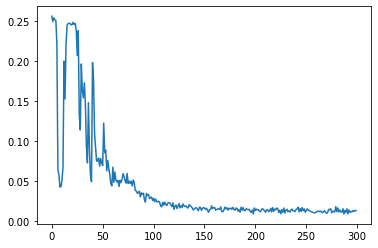

In [21]:
plt.plot(train_loss_list)
plt.show()

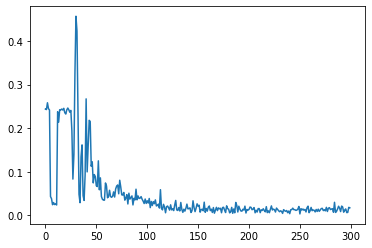

In [23]:
plt.plot(val_loss_list)
plt.show()

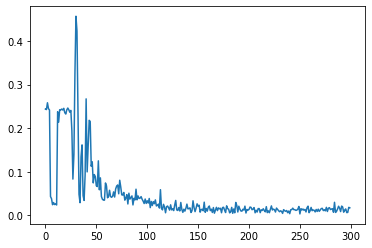

In [16]:
plt.plot(val_loss_list)
plt.show()

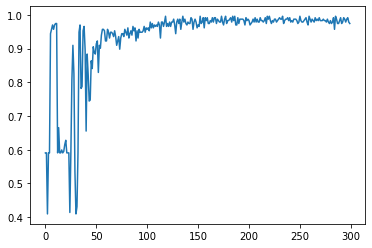

In [17]:
plt.plot(val_acc_list)
plt.show()

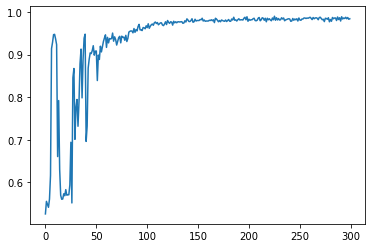

In [18]:
plt.plot(train_acc_list)
plt.show()

In [19]:
# train_loss_list = []
# train_acc_list = []
# val_loss_list = []
# val_acc_list = []